# YOLO

This is the example of my code, where I developed YOLO (you only look once), which is the model for object detection. (https://arxiv.org/abs/1506.02640)

It is a part of the course Deep Learning (homework # 3). Everything is implemetned using Pytorch and Pytorch lightning.

__Instructions__:

In this assignment, you will write and train your own YOLO detector. You will need to figure out the article: understand what format the training pair (x, y) should be, how to translate los from a mathematical formula into Python code - and of course understand and implement the architecture of the model itself.

The sample on which we will train the model consists of a variety of photos of apples, bananas and oranges. Download the data [from here](https://drive.google.com/file/d/1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3/view?usp=sharing ).

In [1]:
# ! pip install xmltodict pytorch-lightning

# !wget --quiet --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3" -O data.zip && rm -rf /tmp/cookies.txt
# !unzip -q data.zip
# !rm data.zip
# !ls -l

## Preparing data

In [4]:
import os
import cv2
import json
import glob
import tqdm
import xmltodict

from IPython.core.display import struct

from typing import List

import pandas as pd
import numpy as np

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

import albumentations as A
import albumentations.pytorch

from PIL import Image

import matplotlib.pyplot as plt

from sklearn.metrics import auc

In [ ]:
class2tag = {"apple": 0, "orange": 1, "banana": 2}

class FruitDataset(Dataset):
    def __init__(self, data_dir, S=7, B=2, C=3, transforms=None):
        data_dir = os.path.join(*os.path.split(data_dir))
        
        self.image_paths = sorted([os.path.join(data_dir, i) for i in os.listdir(data_dir) if "jpg" in i])
        self.box_paths = sorted([os.path.join(data_dir, i) for i in os.listdir(data_dir) if "xml" in i])

        assert len(self.image_paths) == len(self.box_paths)

        self.transforms = transforms
        self.data_dir = data_dir
        
        self.S = S
        self.B = B
        self.C = C

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        height = image.shape[0]
        width = image.shape[1]
        
        boxes, class_labels = self.__get_boxes_from_xml(self.box_paths[idx], height=height, width=width)

        if self.transforms:
            transformed = self.transforms(image=image, bboxes=boxes, class_labels=class_labels)
            image = transformed['image']
            boxes = transformed['bboxes']
    
        return image, self.transform_boxes_classes_to_tensor(boxes, class_labels)

    def __len__(self):
        return len(self.image_paths)

    def __get_boxes_from_xml(self, xml_filename: str, height=None, width=None):
        """
        A method that reads and parses (using xmltodict) the transmitted xml file
        and returns the coordinates of the rectangles of objects in the corresponding photo
        and the name of the object class in each rectangle.
        
        Please note that there can be several objects, or only one.
        """
    
        boxes = []
        class_labels = []
        
        with open(xml_filename, 'r') as f:
            objects = xmltodict.parse(f.read())["annotation"]["object"]
            if isinstance(objects, dict):
                box_dict = objects
                
                label = box_dict["name"]
                label = class2tag[label]

                box = list(map(int, box_dict["bndbox"].values()))
                box = self.__convert_to_yolo_box_params(box, width, height)

                boxes.append(box)
                class_labels.append(label)
            else:
                for box_dict in objects:
                    label = box_dict["name"]
                    label = class2tag[label]

                    box = list(map(int, box_dict["bndbox"].values()))
                    box = self.__convert_to_yolo_box_params(box, width, height)

                    boxes.append(box)
                    class_labels.append(label)

        return boxes, class_labels

    def __convert_to_yolo_box_params(self, box_coordinates: List[int], im_w, im_h):
        """
        Go from [xmin, ymin, xmax, ymax] to [x_center, y_center, width, height].

        Note that the parameters [x_center, y_center, width, height] are
        relative values in the segment [0, 1]

        :param: box_coordinates - the coordinates of the box in the format [xmin, ymin, xmax, ymax]
        :param: im_w - the width of the original image
        :param: im_h - the height of the original image
        
        :return: the coordinates of the box in the format [x_center, y_center, width, height]
        """
        
        ans = []

        ans.append((box_coordinates[0] + box_coordinates[2]) / 2 / im_w)  # x_center
        ans.append((box_coordinates[1] + box_coordinates[3]) / 2 / im_h)  # y_center
      
        ans.append((box_coordinates[2] - box_coordinates[0]) / im_w)  # width
        ans.append((box_coordinates[3] - box_coordinates[1]) / im_h)  # height
        return ans
    
    def transform_boxes_classes_to_tensor(self, boxes, classes):
        responsible_cells = []
        for bbox in boxes:
            cell = (int(bbox[0] / (1 / self.S)), int(bbox[1] / (1 / self.S)))
            responsible_cells.append(cell)
        tensor = torch.zeros((self.S, self.S, 5 * self.B + self.C))
        for i, cell in enumerate(responsible_cells):
            tensor[cell[0], cell[1], :4] = torch.tensor(boxes[i])
            tensor[cell[0], cell[1], 4] = 1
            tensor[cell[0], cell[1], 2 * 5 + classes[i]] = 1
        return tensor

In [443]:
WIDTH, HEIGHT = 448, 448

train_transform = A.Compose([
    A.Resize(height=HEIGHT, width=WIDTH),
    A.HorizontalFlip(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.pytorch.transforms.ToTensorV2(),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

test_transform = A.Compose([
    A.Resize(height=HEIGHT, width=WIDTH),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.pytorch.transforms.ToTensorV2(),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

In [445]:
train_dataset = FruitDataset(
    transforms=train_transform,
    data_dir="data/train"
    )

val_dataset = FruitDataset(
    transforms=test_transform, 
    data_dir="data/test"
    )

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size= 4,
    shuffle=True,)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=4, 
    shuffle=False,)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[0.1449, 0.3555, 0.2868, 0.5734, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000],
        [0.3474, 0.2580, 0.3390, 0.4931, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000],
        [0.5153, 0.3337, 0.3773, 0.5161, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000]])

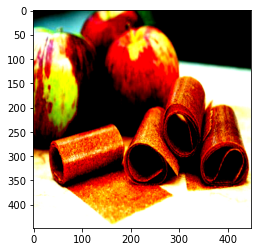

In [455]:
bla = train_dataset[2][0]
plt.imshow(torch.swapaxes(torch.swapaxes(bla, 0, 2), 0, 1))
train_dataset[2][1][train_dataset[2][1][:, :, 4] > 0]

Now let's define a function for calculating the Intersection Over Union at the 4 corners of two rectangles

In [456]:
def intersection_over_union_old(predicted_bbox, gt_bbox) -> float:
    """
    Intersection Over Union for two rectangles 

    :param: predicted_bbox - [x_min, y_min, x_max, y_max]
    :param: gt_bbox - [x_min, y_min, x_max, y_max]
    
    :return: Intersection Over Union
    """

    intersection_bbox = np.array(
        [
            max(predicted_bbox[0], gt_bbox[0]),
            max(predicted_bbox[1], gt_bbox[1]),
            min(predicted_bbox[2], gt_bbox[2]),
            min(predicted_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (predicted_bbox[2] - predicted_bbox[0]) * (predicted_bbox[3] - predicted_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

In [457]:
def convert_to_albumnetations_box_params(box_coordinates: List[int]):
        """
        Go from normalized [x_center, y_center, width, height] to normalized [xmin, ymin, xmax, ymax].
        """
        
        ans = []

        ans.append(box_coordinates[0] - box_coordinates[2] / 2) # xmin
        ans.append(box_coordinates[1] - box_coordinates[3] / 2) # ymin
      
        ans.append(box_coordinates[0] + box_coordinates[2] / 2) # xmax
        ans.append(box_coordinates[1] + box_coordinates[3] / 2) # ymax
        
        return ans

In [458]:
def intersection_over_union(predicted_bbox, gt_bbox) -> float:
    """
    Intersection Over Union for two rectangles

    :param: predicted_bbox - [x_center, y_center, width, height]
    :param: gt_bbox - [x_center, y_center, width, height]
    
    :return: Intersection Over Union
    """

    predicted_bbox = convert_to_albumnetations_box_params(predicted_bbox)
    gt_bbox = convert_to_albumnetations_box_params(gt_bbox)
    
    return intersection_over_union_old(predicted_bbox, gt_bbox)

## Model

In [459]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_max_pool:bool=False, **kwargs):
        
        super().__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

        self.is_maxpool = is_max_pool
        self.maxpool = nn.MaxPool2d(2, stride=2)
        
    def forward(self, x):
        x = self.leakyrelu(self.batchnorm(self.conv(x)))

        if self.is_maxpool:
            x = self.maxpool(x)

        return x
    
class YOLO(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - the number of cells into which the image is divided
        :param: B - the number of predicted rectangles in each cell
        :param: C - number of classes
        """
        
        super(YOLO, self).__init__()

        self.S = S
        self.B = B
        self.C = C
        
        self.CNN1 = CNNBlock(3, 64, is_max_pool=True, kernel_size=7, stride=2)
        
        self.CNN2 = CNNBlock(64, 192, is_max_pool=True, kernel_size=3)
        
        self.CNN3 = CNNBlock(192, 128, is_max_pool=False, kernel_size=1)
        self.CNN4 = CNNBlock(128, 256, is_max_pool=False, kernel_size=3)
        self.CNN5 = CNNBlock(256, 256, is_max_pool=False, kernel_size=1)
        self.CNN6 = CNNBlock(256, 512, is_max_pool=True, kernel_size=3)
        
        self.CNN7 = CNNBlock(512, 512, is_max_pool=False, kernel_size=1, stride=2)
        self.CNN8 = CNNBlock(512, 1024, is_max_pool=False, kernel_size=3)
        self.CNN9 = CNNBlock(1024, 1024, is_max_pool=False, kernel_size=3, stride=2)
        
        self.CNN10 = CNNBlock(1024, 1024, is_max_pool=False, kernel_size=3)
        
        self.leakyrelu = nn.LeakyReLU(0.1)
        
        self.linear1 = torch.nn.Linear(in_features=9216, out_features=4096)
        self.linear2 = torch.nn.Linear(in_features=4096, out_features=self.S * self.S * (5 * self.B + self.C))

        
    def forward(self, x):
        x = self.CNN1(x)
        x = self.CNN2(x)
        x = self.CNN3(x)
        x = self.CNN4(x)
        x = self.CNN5(x)
        x = self.CNN6(x)
        x = self.CNN7(x)
        x = self.CNN8(x)
        x = self.CNN9(x)
        x = self.CNN10(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.leakyrelu(self.linear1(x))
        x = self.linear2(x)
        
        x = x.reshape((-1, self.S, self.S, (self.B * 5 + self.C)))
        
        return x


temp_model = YOLO()
expected_output_shape = temp_model.S * temp_model.S * (5 * temp_model.B + temp_model.C)

assert temp_model(train_dataset[0][0].unsqueeze(0)).reshape(-1).shape[0] == expected_output_shape

## YoloLoss

In [1290]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - the number of cells into which the image is divided
        :param: B - the number of predicted rectangles in each cell
        :param: C - number of classes
        """
        
        super().__init__()
        self.mse = nn.MSELoss(reduction="sum")

        self.S = S
        self.B = B
        self.C = C

        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        S = self.S
        B = self.B
        C = self.C
        
        coord_indicator = target[:, :, :, 4] > 0
        noobj_indicator = target[:, :, :, 4] == 0
        coord_indicator = coord_indicator.unsqueeze(-1).expand_as(target)
        noobj_indicator = noobj_indicator.unsqueeze(-1).expand_as(target)           
                                                                   
        bbox_pred = predictions[coord_indicator].reshape(-1, 5 * B + C)[:, :5 * B].reshape(-1, 5)  
        class_pred = predictions[coord_indicator].reshape(-1, 5 * B + C)[:, 5*B:]   
        
        bbox_target = target[coord_indicator].view(-1, 5 * B + C)[:, :5*B].reshape(-1, 5)
        class_target = target[coord_indicator].view(-1, 5 * B + C)[:, 5*B:]  
        
        # calc loss on cells with objects
        response_mask = torch.zeros(bbox_target.shape)
        not_response_mask = torch.ones(bbox_target.shape)
        pred_iou = torch.zeros(bbox_target.size()[0]).reshape(-1, 1)
        target_confidence = torch.zeros(bbox_target.size())   
        
        for i in range(0, bbox_target.shape[0], B):
            target_i = bbox_target[i]
            for j in range(B):
                pred = bbox_pred[i+j] 
                iou = intersection_over_union(pred.detach().numpy(), target_i.detach().numpy())
                pred_iou[i+j] = iou

        argmax = pred_iou.reshape(-1, 2).argmax(axis=1)
        max_values = pred_iou.reshape(-1, 2).max(axis=1).values

        for i in range(0, argmax.shape[0]):
            response_mask[2*i + argmax[i]] = 1
            not_response_mask[2*i + argmax[i]] = 0
            target_confidence[2*i + argmax[i], 4] = max_values[i]
            
        response_mask = response_mask.bool()
        not_response_mask = not_response_mask.bool()
        
        
        bbox_pred_response = bbox_pred[response_mask].reshape(-1, 5)
        bbox_target_response = bbox_target[response_mask].reshape(-1, 5)

        target_iou = target_confidence[response_mask].reshape(-1, 5)

        loss_1 = F.mse_loss(bbox_pred_response[:, :2], bbox_target_response[:, :2], reduction='sum')
        loss_2 = F.mse_loss(torch.sqrt(bbox_pred_response[:, 2:4].maximum(torch.tensor([0]))), torch.sqrt(bbox_target_response[:, 2:4]), reduction='sum')
        loss_3 = F.mse_loss(bbox_pred_response[:, 4], target_iou[:, 4], reduction='sum')    
        
        loss_class = F.mse_loss(class_pred, class_target, reduction='sum')
        
        noobj_pred = predictions[noobj_indicator].reshape(-1, B*5 + C)
                                                        
        noobj_target = target[noobj_indicator].reshape(-1, B*5 + C)    

        noobj_conf_mask = torch.zeros(noobj_pred.size())

        for b in range(B):
            noobj_conf_mask[:, 4 + b*5] = 1

        noobj_conf_mask = noobj_conf_mask.bool()

        noobj_pred_conf = noobj_pred[noobj_conf_mask]
        noobj_target_conf = noobj_target[noobj_conf_mask]
        loss_noobj = F.mse_loss(noobj_pred_conf, noobj_target_conf, reduction='sum')
        
        loss = self.lambda_coord * (loss_1 + loss_2) + loss_3 + self.lambda_noobj * loss_noobj + loss_class
        loss = loss / float(predictions.size(0))

        return loss
# @ several points were borrowed from https://github.com/motokimura/yolo_v1_pytorch/blob/master/loss.py

## Additional features from the article

In [1222]:
def non_max_suppression_one_class(bboxes, iou_threshold, threshold):
    """
    Non-max suppression for bboxes of one class.
    """
    
    bboxes = sorted(bboxes, key=lambda x: x[4], reverse=True)
    bboxes = [i for i in bboxes if i[4] > threshold]
    
    result = []
    while len(bboxes) > 0:
        result.append(bboxes[0])
        bboxes = [i for i in bboxes[1:] if intersection_over_union(bboxes[0][:4], i[:4]) < iou_threshold]
    
    return np.array(result)

def non_max_suppression(bboxes, iou_threshold, threshold):
    result = np.array([]).reshape(0, 6)
    for label in np.unique(bboxes[:, -1]):
        label_bboxes = bboxes[bboxes[:, -1] == label]
        result = np.concatenate((result, non_max_suppression_one_class(label_bboxes, iou_threshold, threshold).reshape(-1, 6)), axis=0)
    return result    
        

def get_correct_score(pred_boxes, true_boxes, iou_threshold=0.1):
    """
    PR AUC for one class and one object.
    """
    correct = []
    score = []
    for pred_box in pred_boxes:
        iou = 0
        for true_box in true_boxes:
            iou = max(iou, intersection_over_union(pred_box[:4], true_box[:4]))
        if iou > iou_threshold:
            correct.append(1)
        else:
            correct.append(0)
        score.append(pred_box[4])
    
    return correct, score
    

def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.3):
    avg_precision = []
    for label in [0, 1, 2]:
        all_correct = []
        all_score = []
        for i in range(len(pred_boxes)):
            mask_pred = pred_boxes[i][:, -1] == label
            mask_true = true_boxes[i][:, -1] == label
            correct, score = get_correct_score(pred_boxes[i][mask_pred], true_boxes[i][mask_true], iou_threshold)
            all_correct += correct
            all_score += score
        precision, recall, _ = sklearn.metrics.precision_recall_curve(all_correct, all_score)
        avg_precision.append(sklearn.metrics.auc(recall, precision))
    return np.mean(avg_precision), avg_precision
        

def get_bound_boxes(loader, model, iou_threshold=.5, threshold=.2, S=7, B=2, C=3):
    all_pred_boxes = []
    all_true_boxes = []
    for imgs, target in loader:
        predictions = model(imgs)
        for pred in predictions:
            pred_class = pred[:, :, -3:]
            pred_class = pred_class.reshape(-1, C)
            pred_class = pred_class.detach().numpy()
            pred = pred[:, :, :-3]
            pred = pred.reshape(-1, 5 * B)
            pred = pred.detach().numpy()
            mask = np.zeros((pred.shape[0], B)).astype(bool)
            for b in range(B):
                mask[:, b] = (pred[:, 5*b +4] > threshold)
            pred = pred.reshape(-1, B, 5)
            pred = pred[mask]
            pred_class = np.repeat(pred_class.argmax(axis=1)[:, None], B, axis=1)[mask][:, None]
            pred = np.concatenate((pred, pred_class), axis=1)
            all_pred_boxes.append(pred)
        for tar in target:
            tar = tar[tar[:, :, 4] > 0]
            tar = tar.detach().numpy()
            tar_class = tar[:, -3:].argmax(axis=1)
            tar = tar[:, :5]
            tar = np.concatenate((tar, tar_class[:, None]), axis=1)
            all_true_boxes.append(tar)
    return all_pred_boxes, all_true_boxes

## Training

In [1223]:
class YOLOLearner(pl.LightningModule):
    def __init__(self, model) -> None:
        super().__init__()

        self.model = model
        self.loss = YoloLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-5)

    def forward(self, x) -> torch.Tensor:
        return self.model(x)

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        y_hat = self.model(images)
        loss = self.loss(y_hat, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

In [474]:
model = YOLO()
n_epochs = 10

yolo_learner = YOLOLearner(model=model)  ## YOUR CODE

# device = "gpu" if torch.cuda.is_available() else "cpu"
device = "cpu"
trainer = pl.Trainer(accelerator=device, max_epochs=n_epochs)

trainer.fit(yolo_learner, train_dataloader, val_dataloader)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params
-----------------------------------
0 | model | YOLO     | 65.9 M
1 | loss  | YoloLoss | 0     
-----------------------------------
65.9 M    Trainable params
0         Non-trainable params
65.9 M    Total params
263.669   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## Results

Попробуйте понять насколько хороши ваши показатели. Если числа кажутся подозрительно низкими - возможно вам стоит перепроверить ваше решение. 

In [1225]:
## mAP Train
all_pred_boxes, all_true_boxes = get_bound_boxes(train_dataloader, model)
mean_average_precision(all_pred_boxes, all_true_boxes)

(0.4587615451457068,
 [0.40968764981070155, 0.4641759523582901, 0.5024210332681287])

In [1226]:
## mAP Validation
all_pred_boxes, all_true_boxes = get_bound_boxes(val_dataloader, model)
mean_average_precision(all_pred_boxes, all_true_boxes)

(0.47852347420414826,
 [0.5407286440206664, 0.4683124745624745, 0.426529304029304])